### LSUV - Layer-Wise Sequential Unit-Variance

In this notebook we quickly explore the efficacy of weight initializations and implement the LSUV algorithm.
The effectiveness of LSUV is measured by the accuracy of the trained network after 3 epochs and other metrics on the activations.

*adapted from Fastai2023-Part2 - building Miniai*

In [1]:
import sys, gc, traceback
import torch
import random
import numpy as np
from torch import nn, tensor, optim
from torch.nn import init
import matplotlib
import matplotlib.pyplot as plt

from operator import itemgetter
from functools import partial

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import default_collate

import torchvision.transforms.functional as TF

In [2]:
from datasets import load_dataset, load_dataset_builder

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
matplotlib.rcParams['image.cmap'] = 'gray'

In [4]:
def set_seed(seed):
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

### Load Fashion MNIST from Huggingface datasets

In [ ]:
name = 'fashion_mnist'
ds_dict = load_dataset(name)

In [6]:
ds_dict

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [7]:
train_ds, test_ds = ds_dict['train'], ds_dict['train']

In [8]:
def transform(b): 
    b['image'] = [TF.to_tensor(o) for o in b['image']]
    return b

In [9]:
train_ds, test_ds

(Dataset({
     features: ['image', 'label'],
     num_rows: 60000
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 60000
 }))

In [10]:
t_train_ds = train_ds.with_transform(transform)
t_test_ds = test_ds.with_transform(transform)

In [11]:
type(t_train_ds[0]['image']) , type(train_ds[0]['image'])  

(torch.Tensor, PIL.PngImagePlugin.PngImageFile)

In [12]:
bs = 256

The `DataLoader` class accepts dictionaries, so it is fine to directly feed it the huggingface train/test dicts: 

In [13]:
train_dl = DataLoader(t_train_ds, batch_size=bs, num_workers=4, pin_memory=True)
test_dl = DataLoader(t_test_ds, batch_size=bs, num_workers=4, pin_memory=True)

In [14]:
batch_ = next(iter(train_dl))
batch_['image'].shape, batch_['label'].shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

We can also transform the dictionary into a tuple, the usual pytorch format:

In [15]:
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [16]:
train_dl = DataLoader(t_train_ds, batch_size=bs, collate_fn=collate_dict(t_train_ds), num_workers=4, pin_memory=True)
test_dl = DataLoader(t_test_ds, batch_size=bs, collate_fn=collate_dict(t_test_ds), num_workers=4, pin_memory=True)

In [17]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

To plot the image, we can use `plt.imshow` - we note that the colors will be inverted so as $img \in [0,1]$ a simple $(img-1)\times(-1)$ will give the right rendering:

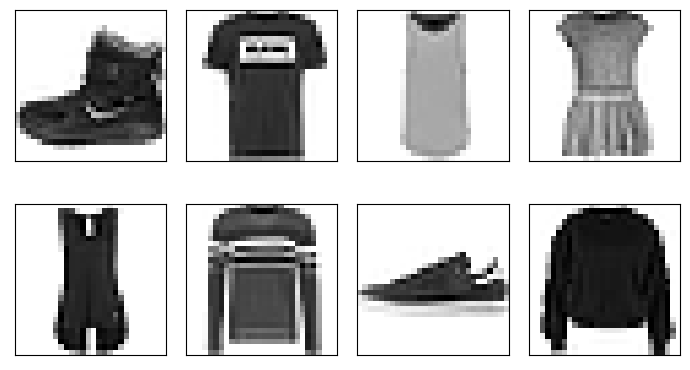

In [18]:
fig, axs = plt.subplots(2,4, figsize=(7,5), tight_layout=True)
for i,ax in enumerate(axs.flatten()):
    ax.imshow((xb[i].squeeze()-1)*-1);
    ax.set_xticks([]) 
    ax.set_yticks([])

### Simple CNN

We can now build a simple CNN model. The images are $28\times28$ so with a `stride` of 2 the images will shrink by a factor of 2 at each `Conv2d` layer, going from $28\times28$ to $14\times14$ to $7\times7$ to $4\times4$ to $2\times2$ to $1\times1$ in 5 `Conv2d` layers: 

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [21]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None), nn.Flatten()).to(device)

In [22]:
model = get_model()
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [23]:
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [24]:
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [25]:
def fit(epochs, model, loss_func, lr, opt_func, train_dl, valid_dl):
    opt = opt_func(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

### Default Pytorch init 

The weights of a `Conv2d` in Pytorch are initialized by sampling from a Uniform distribution $\mathcal{U}\Bigl[-\frac{1}{\sqrt{k}},\frac{1}{\sqrt{k}}\Bigr ]$, with $k = C_{in}\times ker_0\times ker_1$ the number of input channels times the kernel size, $ker_0 = ker_1$ if the kernels are squares. <br>
This initialization corresponds to the uniform Xavier initialization and is adapted for $tanh$ activations. <br>
We can see how the weights learn with this default initialization and use this result as a baseline.

We can track the means, standard deviations and distribution of the weight values through training to observe their dynamic change. We can do so with pytorch forward hooks: 

In [27]:
def run(model, lr=0.1, layer_type=nn.Conv2d):
    set_seed(1)
    
    global act_means
    global act_stds
    global act_hists
    
    act_means = [[] for m in model.modules() if isinstance(m, layer_type)]
    act_stds = [[] for m in model.modules() if isinstance(m, layer_type)]
    act_hists = [[] for m in model.modules() if isinstance(m, layer_type)]
    hooks = []
    
    i=0
    for m in model.modules():
        if isinstance(m, layer_type): 
            hooks.append(m.register_forward_hook(partial(append_stats,i)))
            i += 1
    
    fit(3, model, F.cross_entropy, lr, optim.SGD, train_dl, test_dl)
    
    remove_hooks(hooks)
    
    plot_stats()
    color_dim()
    dead_chart()

In [28]:
def append_stats(i, model, inputs, outputs):
    act_means[i].append(outputs.detach().cpu().mean())
    act_stds[i].append(outputs.detach().cpu().std())
    act_hists[i].append(outputs.detach().cpu().abs().histc(40,0,10))

In [29]:
def remove_hooks(hook_list):
    for h in hook_list: h.remove()

In [30]:
def plot_stats():
    fig, axs = plt.subplots(1,2, figsize=(10,3))
    axs[0].set_title('means')
    axs[1].set_title('stds')
    for mean, std in zip(act_means[:-1], act_stds[:-1]): 
        axs[0].plot(mean)
        axs[1].plot(std)
    for ax in axs: ax.legend(range(5));

In [31]:
def get_hist(h): return torch.stack(h).t().float().log1p()

In [32]:
def color_dim():
    k = len(act_means)//2 if len(act_means)%2 == 0 else len(act_means)//2 + 1
    fig,axes = plt.subplots(k,2, figsize=(11,5))
    for i,(ax,h) in enumerate(zip(axes.flatten(), act_hists)):
        ax.set_title(f'Layer_{i}')
        ax.imshow(get_hist(h).numpy(), origin='lower', cmap='viridis', aspect=7)
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.axis('off')

In [33]:
def get_min(h):
    h1 = torch.stack(h).t().float()
    return h1[0]/h1.sum(0)

In [34]:
def dead_chart():
    k = len(act_means)//2 if len(act_means)%2 == 0 else len(act_means)//2 + 1
    fig,axes = plt.subplots(k,2, figsize=(11,5))
    for ax,h in zip(axes.flatten(), act_hists):
        ax.plot(get_min(h))
        ax.set_ylim(0,1)

> We'll first set the hooks on the `Conv2d` layers to get the statistics before the activation becasue ReLUs truncate the outputs at 0 and so does not give a goods idea of the number of outputs that are non-zero in the Conv layers. Since the mean and std after the activation should tend to 0 and 1 respectively, we'll look at their evolution after the ReLUs as well. 

In [39]:
set_seed(1)
model = get_model()

0 0.7165730694770813 0.74075
1 0.5184550535043081 0.8134166667302449
2 0.45835670873324075 0.8333833333651225


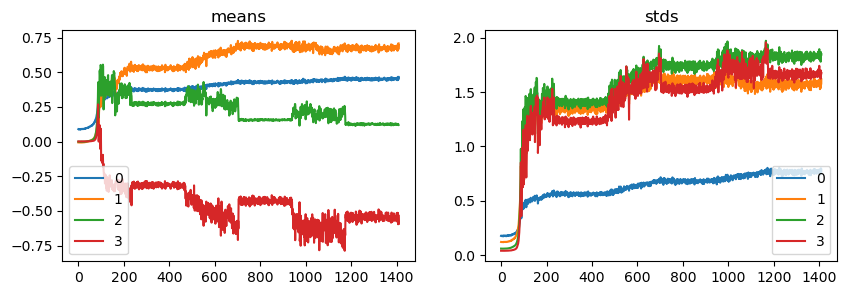

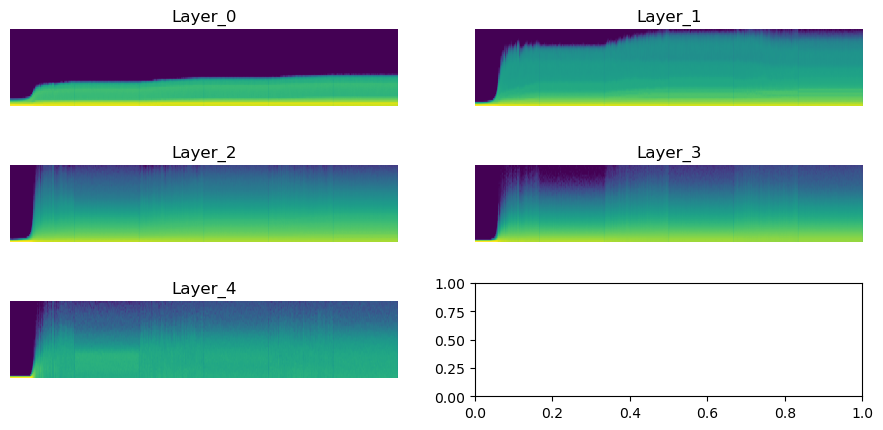

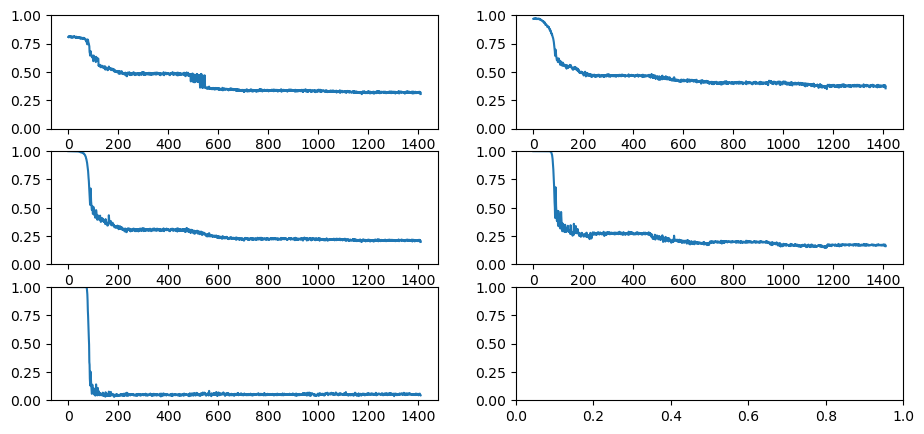

In [36]:
run(model, lr=0.2, layer_type=nn.Conv2d)

>Ideally we would like to see the `Conv2d` to yield outputs that, after the ReLU will have statistics close to $\sigma^{2}\sim 1$, $\mu \sim 0$. Here we see the stds around 2. If the outputs are symmetrically distributed around their mean and that the mean is close to 0, one should get an std of about 1 after the relu activations since it only keeps the positive ouputs. <br> 

>The color plot shows an histogram of the absolute value of the outputs of the `Conv2d` layers. The purpose of this graph is to see if the layers have most of their weights activated, that is, non-zero. This gives a good idea of the efficiency of training. <br>

>The last graph gives a quantitative information about the histogram color graph, it shows the evolution of the proportion of outputs that have values between 0 and 0.25 (values of the histogarm range from 0 to 10 and the histogram has 40 bins) during training. <br>

>As the network learns, the number of zero or near zero outputs decreases. The drop from high inefficiency (between 75% and 100% of the outputs in the first histogram bin $[0, 0.25]$) to smoother learning happens after about 100 minibatches. The proportion of outputs close to 0 in the first 4 `Conv2d` layers is above 25%, close to 40-50% for most.

Now looking at the `nn.ReLU`s:

In [37]:
set_seed(1)
model = get_model()

0 0.7165730694770813 0.74075
1 0.5184550535043081 0.8134166667302449
2 0.45835670873324075 0.8333833333651225


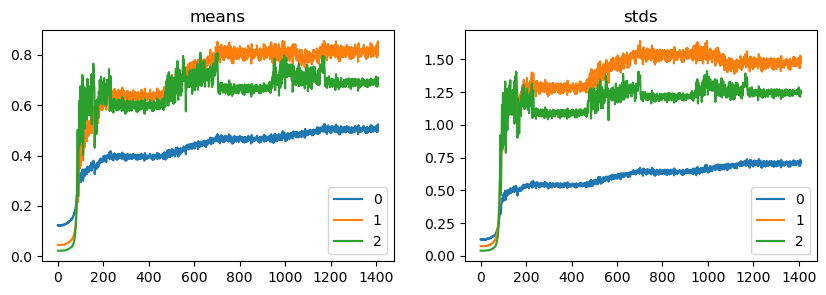

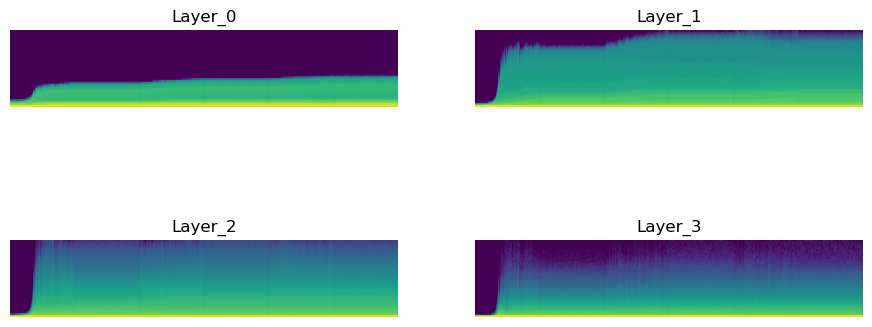

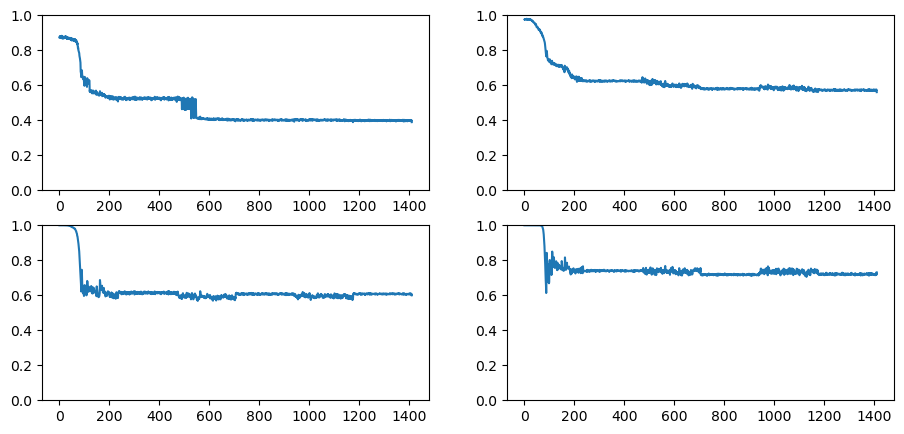

In [38]:
run(model, lr=0.2, layer_type=nn.ReLU)

> The means can't be zero because it's a relu, but as expected the stds are closer to 1.25 for the two last relus. The first layer is off, as sign that the learning is suboptimal.

### Input Normalization

The Xavier uniform initialization is not optimal for our network since we use `ReLU` activations. Before applying the appropriate initialization, we can normalize the inputs: 

Assuming that the first batch `xb` is representative of the statistics of the whole trainset, we can normalize with `xmean` and `xstd`:

In [40]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd

(tensor(0.29), tensor(0.35))

We can modify the data with the `transform` function and rebuild the dataloader:

In [41]:
def transform(b): 
    b['image'] = [(TF.to_tensor(o)-xmean)/xstd for o in b['image']]
    return b

In [42]:
t_train_ds = train_ds.with_transform(transform)
t_test_ds = test_ds.with_transform(transform)

In [43]:
train_dl = DataLoader(t_train_ds, batch_size=bs, collate_fn=collate_dict(t_train_ds), num_workers=4, pin_memory=True)
test_dl = DataLoader(t_test_ds, batch_size=bs, collate_fn=collate_dict(t_test_ds), num_workers=4, pin_memory=True)

In [44]:
xb, yb = next(iter(train_dl))
xb.mean(), xb.std()

(tensor(    -0.00), tensor(1.00))

Looking at the `Conv2d`s:

In [45]:
set_seed(1)
model = get_model()

0 0.5907028452555338 0.7914166666666667
1 0.4686508408387502 0.8322333333333334
2 0.40049030085404713 0.8551833333333333


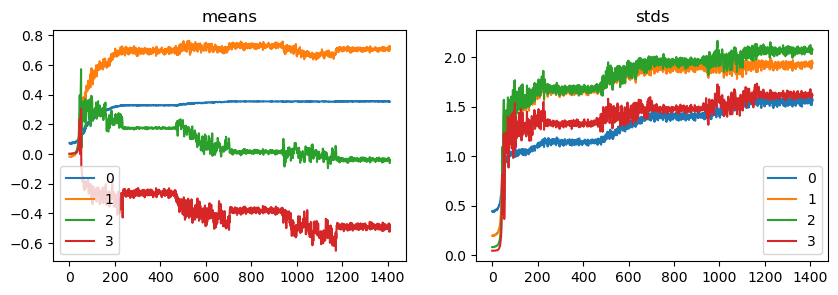

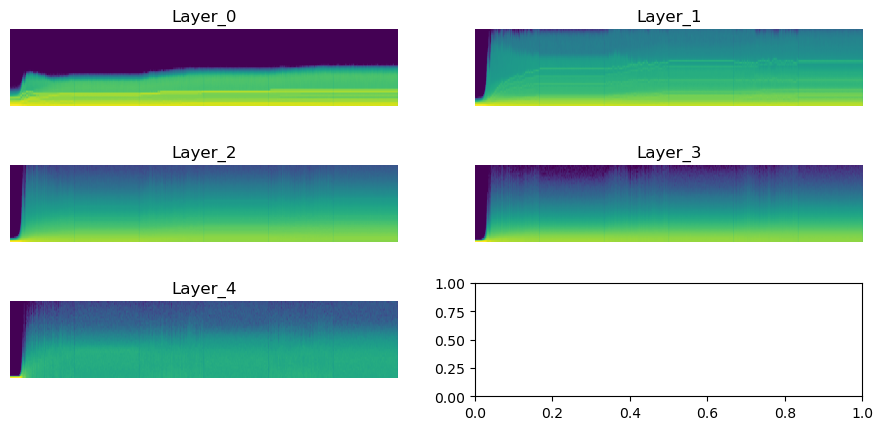

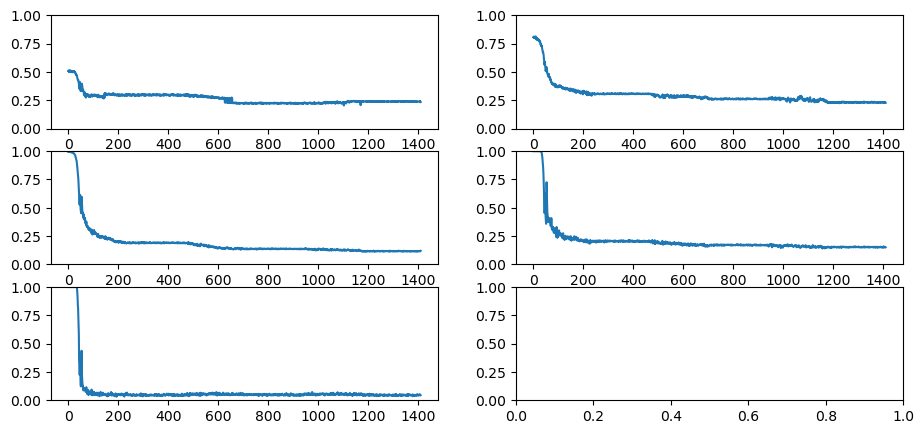

In [46]:
run(model, lr=0.2, layer_type=nn.Conv2d)

>The accuracy has improved, the network converged faster likely due to a better transmission of the information through the layers thanks to input normalization. <br>

>The stds still approaches about 2. <br>

>Some artefacts and non smooth behavior remain at the beginning and in the first two layers in the color graph. <br>

>The proportion of `Conv2d` outputs that are almost 0 dropped faster, in about 50 iterations, from 50%-100% to 25% or lower.

In [47]:
set_seed(1)
model = get_model()

0 0.5907028452555338 0.7914166666666667
1 0.4686508408387502 0.8322333333333334
2 0.40049030085404713 0.8551833333333333


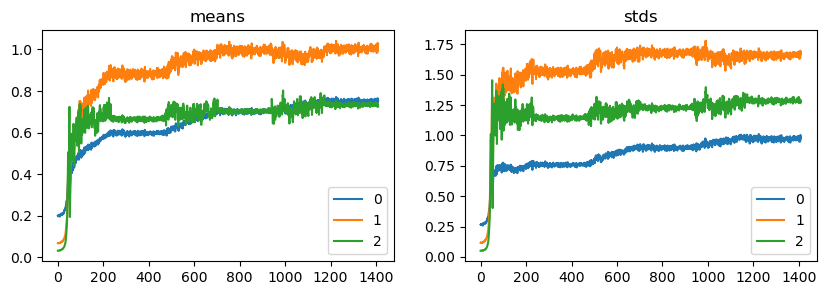

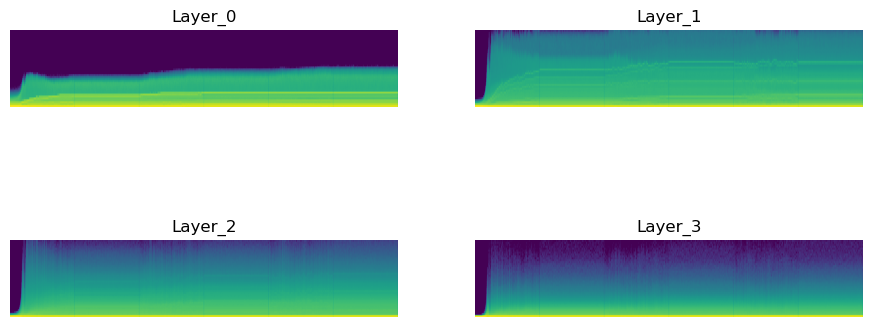

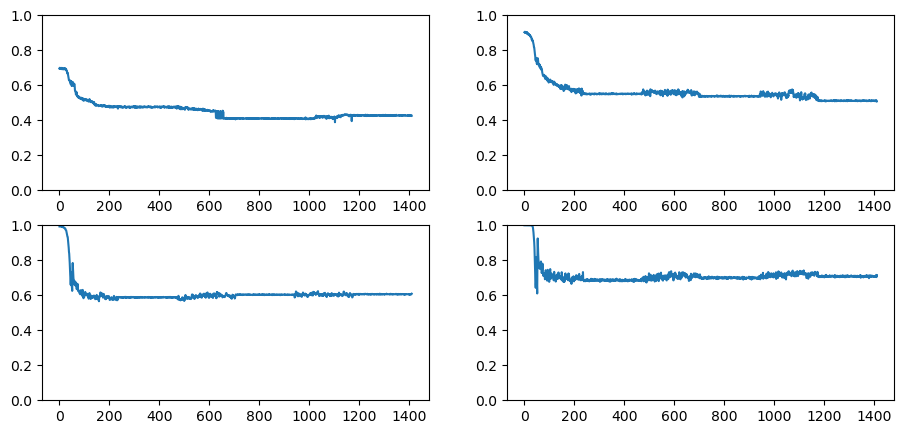

In [48]:
run(model, lr=0.2, layer_type=nn.ReLU)

> Same as before, the first layers behavior is not as different as the two others thanks to the normailzed inputs.

### Kaiming init

> Glorot/Xavier init --> scale inputs by $1/\sqrt{n_{in}}$, $n_{in}$ the number of inputs of a given layer. <br> 
It's ok for a network without non linearities (Glorot based his work on linear activations) but does not work to keep each layer's outputs stats $\sigma^{2}\sim 1$, $\mu \sim 0$ with ReLUs for instance. It is quite obvious since ReLUs remove numbers below 0. The weights are sampled from a uniform distribution in the [original paper](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).

> Kaiming/He init --> scale inputs by $2/\sqrt{n_{in}}$, $n_{in}$ the number of inputs of a given layer. <br> 
This initialization takes into account the ReLU activations and work well to keep $\sigma^{2}\sim 1$ throughout the network. 
Now the initialization allows to still pass information after several layers of depth. The weights are sampled from a normal distribution in the [original paper](https://arxiv.org/abs/1502.01852).

_Note_ : Every torch module has the method apply that allows to apply a function to all the modules in the module. For instance, we can apply an init function.

In [49]:
def init_weights(m, leaky=0):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)

Stats on the `Conv2d`s:

In [51]:
set_seed(1)
model = get_model().apply(init_weights)

0 0.4522270388841629 0.8334833333969116
1 0.3862883079449336 0.8587500000635783
2 0.3576120318333308 0.8703833333333333


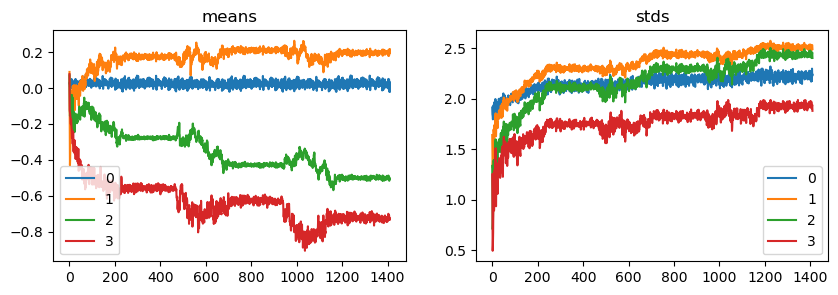

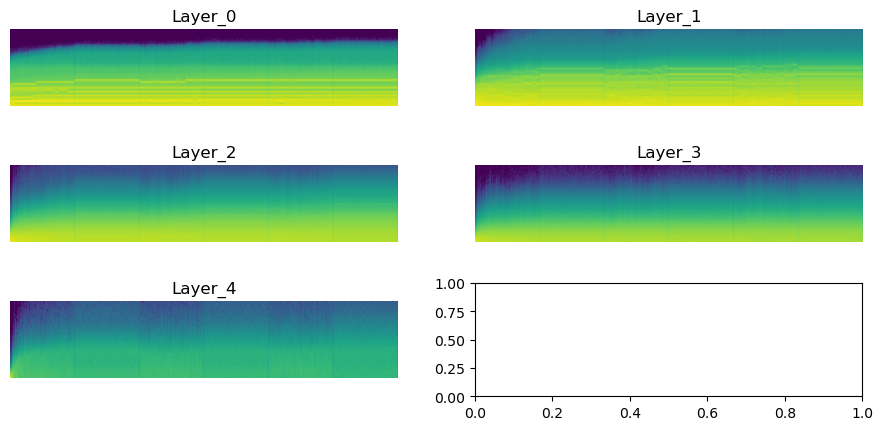

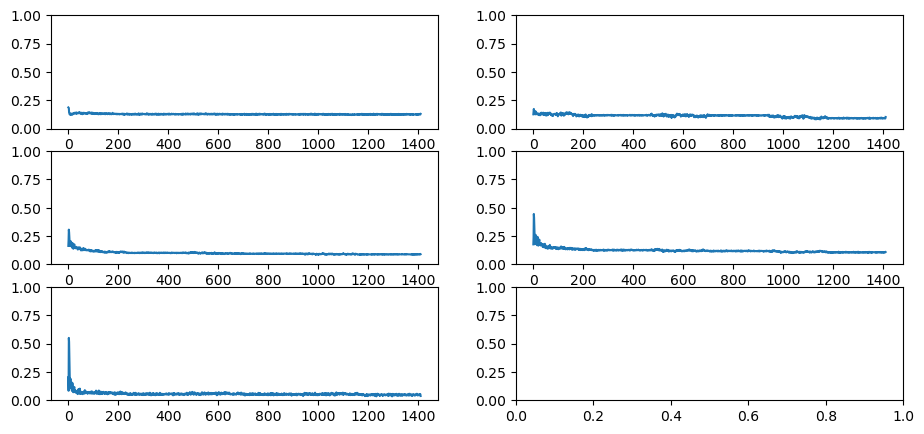

In [52]:
run(model, lr=0.2)

> The accuracy improved, and reached 87% after 3 epochs. The means of the first and second layers are very close to 0, then the rest of the layers mean drop to negative values. The stds are still around 2.

> In the color histogram plot the result is very good, the distribution of values is smoother and more spreadout from the first layer on.

> It shows in the 'dead outputs' graph, the proportion of outputs that are in the first bin $[0,0.25]$ is very low, below 15% almost from the beginning for all layers.

In [53]:
set_seed(1)
model = get_model().apply(init_weights)

0 0.4522270388841629 0.8334833333969116
1 0.3862883079449336 0.8587500000635783
2 0.3576120318333308 0.8703833333333333


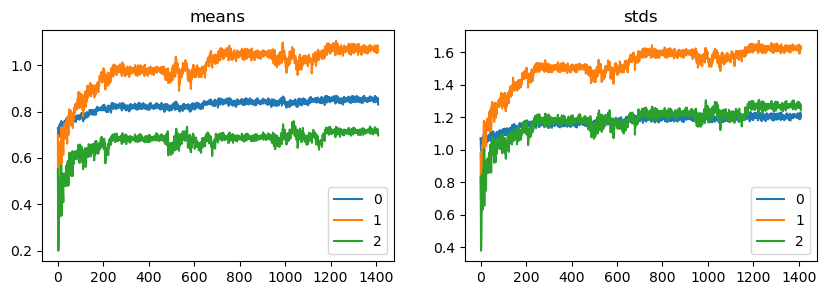

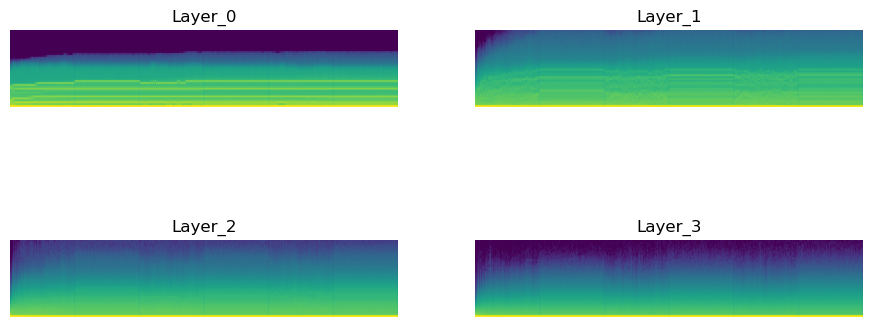

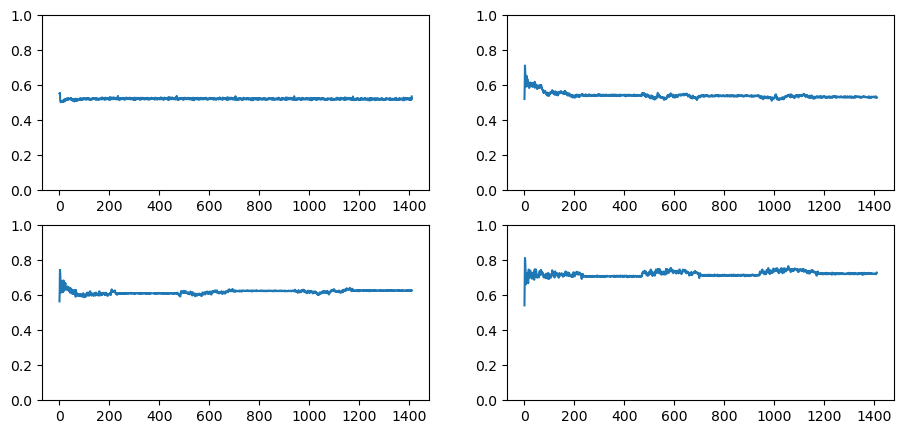

In [54]:
run(model, lr=0.2, layer_type=nn.ReLU)

> The means are still of as expected but the stds are about 1 for the first and third ReLUs. 

### General ReLU

In order to fix the mean jumps from the Conv2d outputs to the relu activations, we need to allow negative values in the activations outputs.
We can build `GeneralRelu`, modified `leakyReLU` rectifier with a vertical shift:

In [55]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
    
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

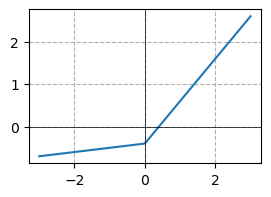

In [56]:
x = torch.linspace(-3, 3, 100)
plt.figure(figsize=(3,2))
plt.plot(x, GeneralRelu(leak=0.1, sub=0.4)(x))
plt.grid(True, which='both', ls='--')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5);

We can use the Kaiming initialization adapted to the slope (leakiness) in the negative x values:

In [59]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [60]:
set_seed(1)
model = get_model(act_gr).apply(iw)

0 0.4860240015188853 0.8285833333969116
1 0.37894635757605233 0.8621833333651224
2 0.3325243157784144 0.8780166667302449


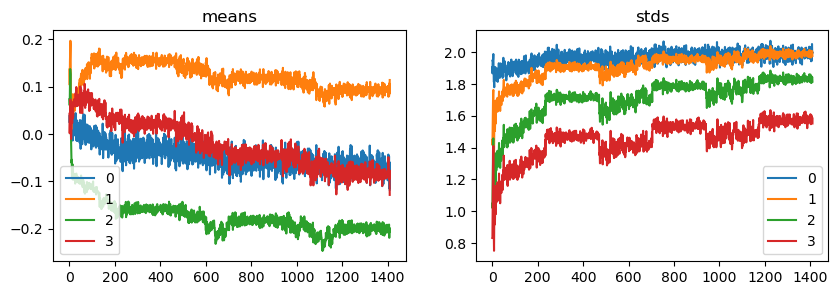

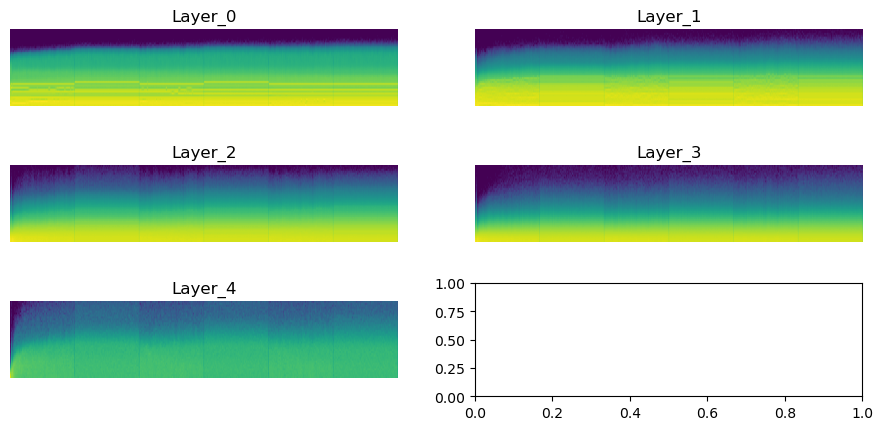

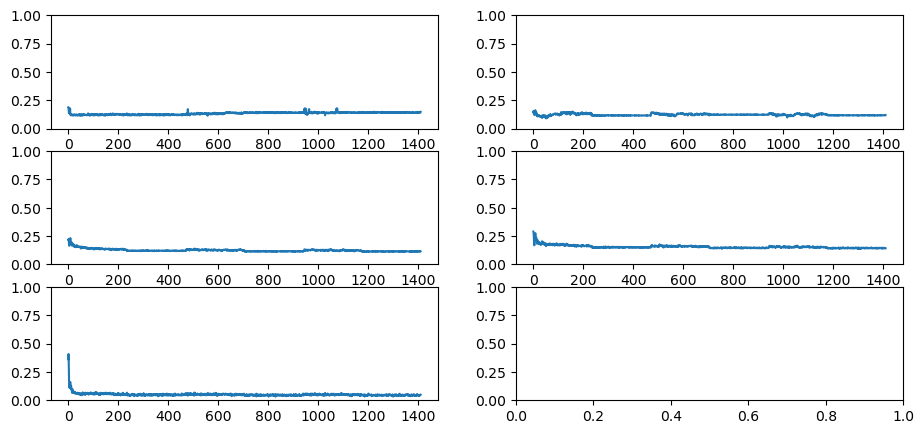

In [61]:
run(model, lr=0.2)

> The result is very good, the accuracy increased to 87.8%, a gain of almost 1%. The means are now close to 0 and the stds are all approaching 2 as the number of minibatches increases.  

> The proportion of dead activations is at 20% or below, closer to 10-15% for most layers.

> On the color histogram we can see a smooth shading from 0 to 10.<br>

Let's perform again the calculation but this time looking again at the `GeneralRelu` layers:

In [62]:
set_seed(1)
model = get_model(act_gr).apply(iw)

0 0.4860240015188853 0.8285833333969116
1 0.37894635757605233 0.8621833333651224
2 0.3325243157784144 0.8780166667302449


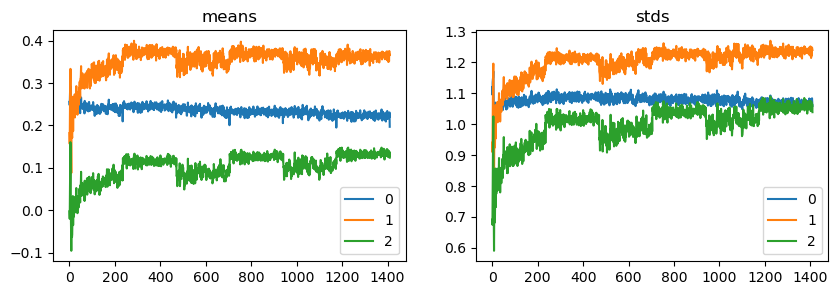

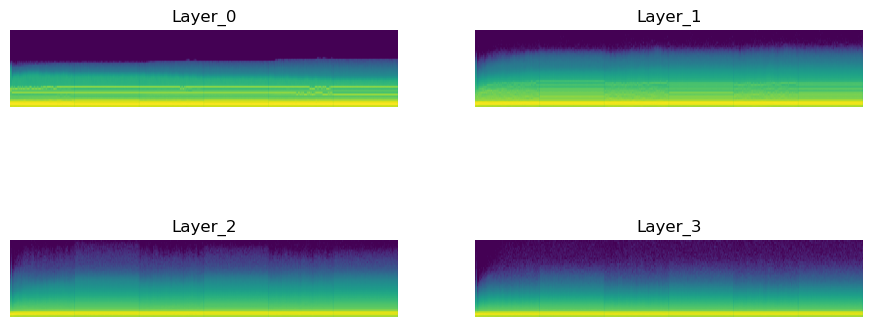

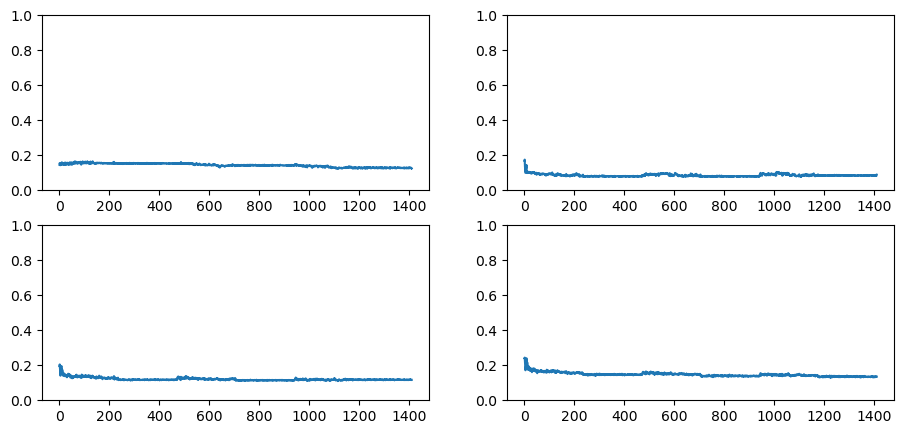

In [63]:
run(model, lr=0.2, layer_type=GeneralRelu)

> The means are a bit higher than 0, the stds are close to 1.  

> The proportion of dead activations are also close to 10-15% for all layers.

> On the color histogram on can see a thick line of activations at the bottom, the previous histogram showed a smoother distribution of the outputs. It is probably due to the GeneralRelu transformation of the Conv2d outputs, a conv activation at 0 will give -0.4 and as we take the absolute value of the activations to plot the color map, it becomes a count at 0.4.<br>

We can see that properly initializing the network's weights is very important and leads to a much better accuracy. We showed it for relu and general relu, but how can one find a good way to initialize the weights for any activation function?

### LSUV - Layer-Wise Sequential Unit-Variance

In a paper called [All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf), the authors introduce *Layer-wise Sequential Unit-Variance* (*LSUV*), a generic way to initialize a model. <br>
The idea is to initialize the model with gaussian noise (in the paper, the algorithm suggests that one should perform an orthonormal matrix initialization of the weights, Gaussian noise works but leads to very slightly worse performance), then pass through only one batch of the training set and calculate the mean and std of the outputs of each Conv layer. <br>
If the mean and std are too high, divide the weights by a bit and repeat until they get to $\sigma^{2}\sim 1$, $\mu \sim 0$. <br>
And then repeat the same process for all the layers.

We can use Hooks to implement this algorithm.

In [64]:
class Hook():
    def __init__(self, m, f): 
        self.hook = m.register_forward_hook(partial(f, self))
        self.mod_nm = type(m).__name__
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [65]:
def _lsuv_stats(hook, mod, inp, outp):
    acts = outp.detach().cpu()
    hook.mean = acts.mean()
    hook.std = acts.std()

In [66]:
def lsuv_init(m, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
#         while model(xb) is not None and (abs(h.std**2-1)>1e-3 or abs(h.mean)>1e-3):
        while model(xb) is not None and abs(h.std**2-1)>1e-3:
            print('before', h.mean, h.std)
            m.bias -= h.mean
            m.weight.data /= h.std
        print('after', h.mean, h.std)
    print()
    h.remove()

Here we perform the adjusment on the outputs of the `Conv2d` layers.

In [67]:
set_seed(1)
model = get_model()
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]
for m in convs: lsuv_init(m, xb.to(device))

before tensor(0.07) tensor(0.44)
before tensor(0.01) tensor(0.95)
before tensor(0.00) tensor(1.00)
after tensor(    0.00) tensor(1.00)

before tensor(-0.05) tensor(0.39)
before tensor(-0.06) tensor(0.99)
after tensor(-0.00) tensor(1.00)

before tensor(0.01) tensor(0.37)
before tensor(0.02) tensor(0.99)
after tensor(0.00) tensor(1.00)

before tensor(0.01) tensor(0.35)
before tensor(0.01) tensor(1.00)
after tensor(    0.00) tensor(1.00)

before tensor(0.01) tensor(0.20)
before tensor(0.09) tensor(0.99)
after tensor(0.00) tensor(1.00)



0 0.4372187452872594 0.8436333333651225
1 0.3565664598226547 0.8711666666984558
2 0.3254535896062851 0.8820000000635783


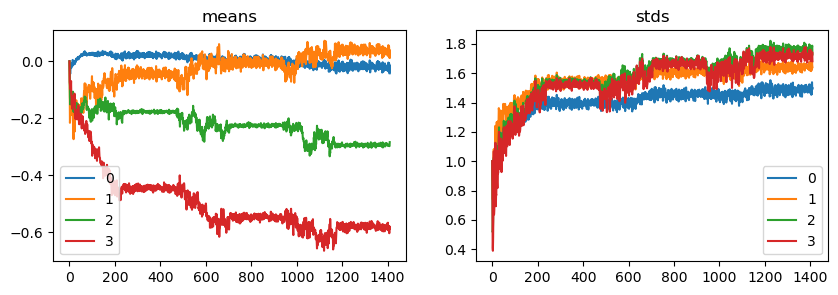

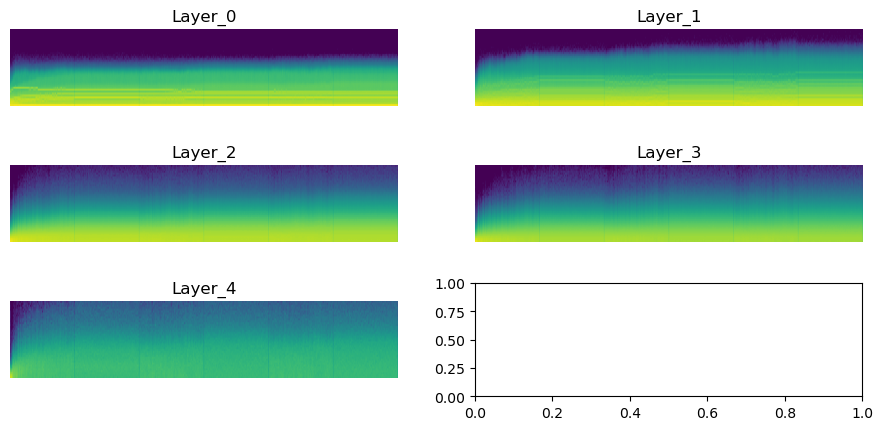

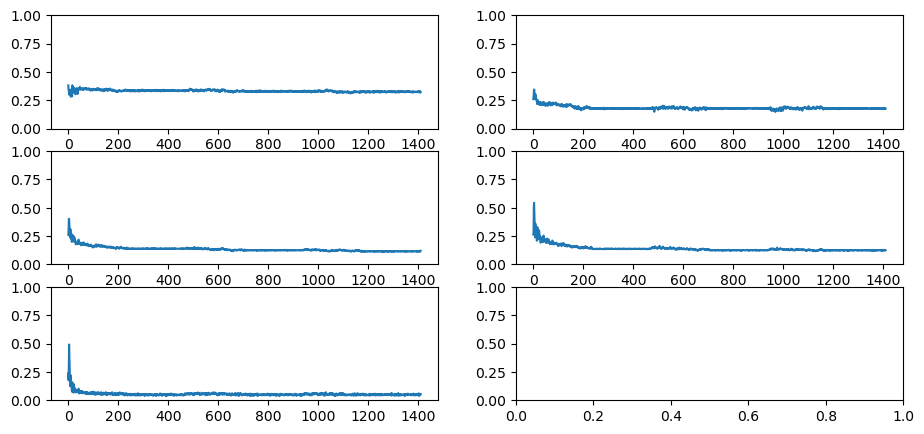

In [68]:
run(model, lr=0.2)

> The accuracy reached 88% only with the input initialization and LSUV.
> We note that the first Conv layer has >25% of its outputs at or near 0

**LSUV and GeneralReLU:**

In [69]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [70]:
set_seed(1)
model = get_model(act_gr).apply(iw)
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]
for m in convs: lsuv_init(m, xb.to(device))

before tensor(0.03) tensor(1.90)
before tensor(0.02) tensor(1.01)
after tensor(0.00) tensor(1.00)

before tensor(0.09) tensor(0.74)
before tensor(0.03) tensor(1.00)
after tensor(-0.00) tensor(1.00)

before tensor(0.06) tensor(0.70)
after tensor(0.03) tensor(1.00)

before tensor(-0.01) tensor(0.75)
before tensor(-0.00) tensor(1.00)
after tensor(    -0.00) tensor(1.00)

before tensor(-0.16) tensor(0.58)
before tensor(-0.11) tensor(1.00)
after tensor(-0.00) tensor(1.00)



0 0.44523298817475637 0.838466666730245
1 0.3830860320965449 0.8590500000635782
2 0.3495739466746648 0.8702500000635783


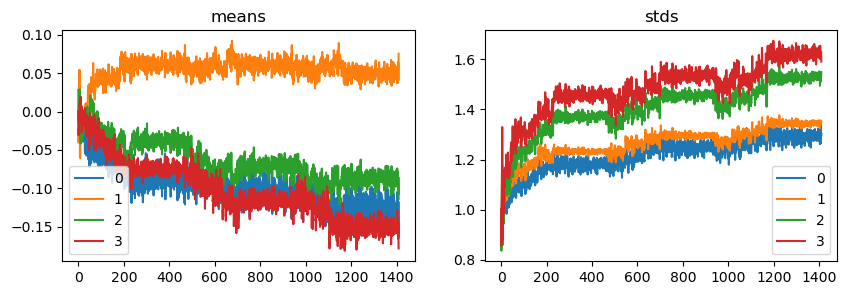

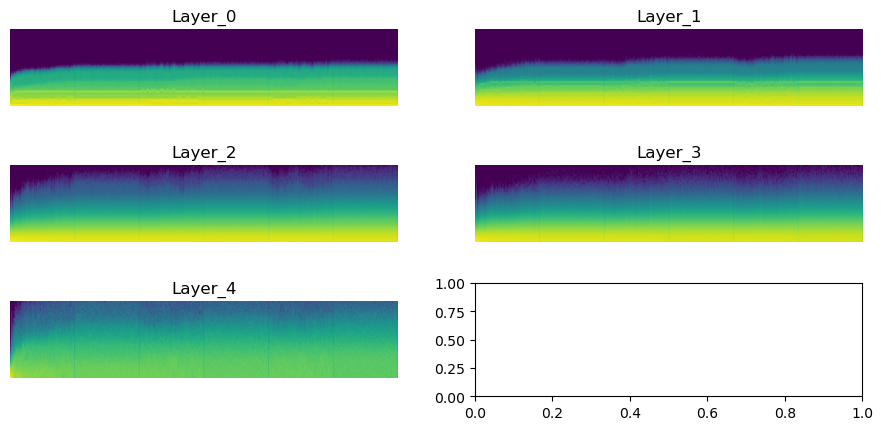

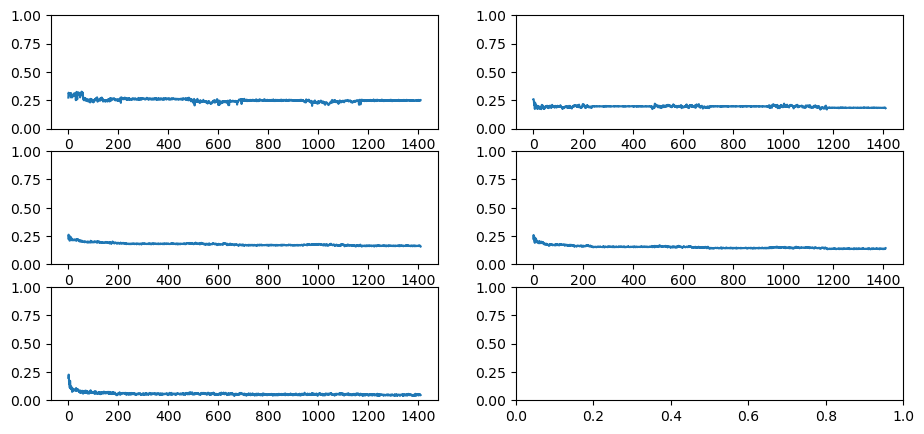

In [71]:
run(model, lr=0.2)

> The means are now at 0, the stds increase to 1.6

**LSUV modifying the `Conv2d` layers so the output of `GeneraRelu` gives a mean 0 variance 1** 

We can modify the Conv2d weights and use the stats of the activations of the GeneralRelu:

In [74]:
def lsuv_init(m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std**2-1)>1e-3 or abs(h.mean)>1e-3):
#         while model(xb) is not None and abs(h.std**2-1)>1e-3:
            print('before', h.mean, h.std)
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
        print('after', h.mean, h.std)
    print()
    h.remove()

In [75]:
set_seed(1)
model = get_model(act_gr).apply(iw)
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
for ms in zip(relus, convs): lsuv_init(*ms, xb.to(device))

before tensor(0.26) tensor(1.12)
before tensor(0.05) tensor(0.93)
before tensor(0.07) tensor(0.99)
before tensor(0.04) tensor(0.98)
before tensor(0.03) tensor(0.99)
before tensor(0.03) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
after tensor(0.00) tensor(1.00)

before tensor(0.13) tensor(0.84)
before tensor(0.15) tensor(0.97)
before tensor(0.08) tensor(0.96)
before tensor(0.07) tensor(0.98)
before tensor(0.04) tensor(0.98)
before tensor(0.03) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before ten

0 0.47980526668230694 0.8257
1 0.3957940753698349 0.8559833333969116
2 0.3451091584444046 0.8717833333651225


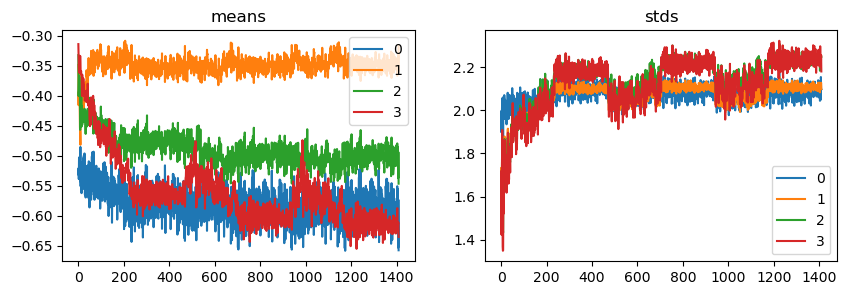

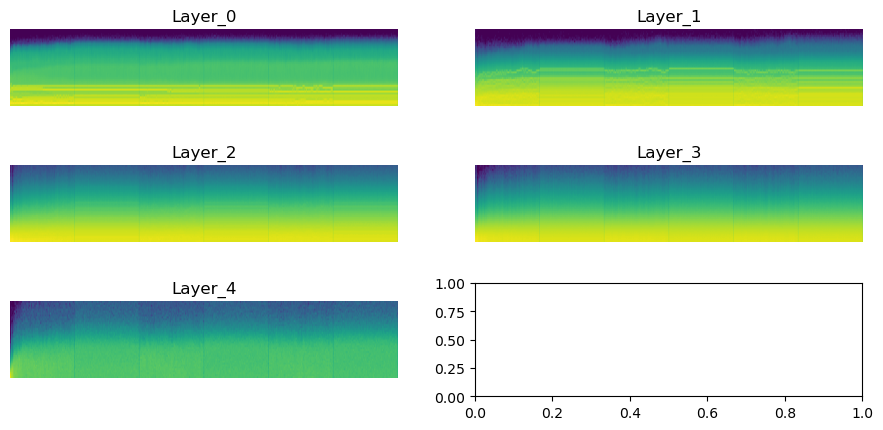

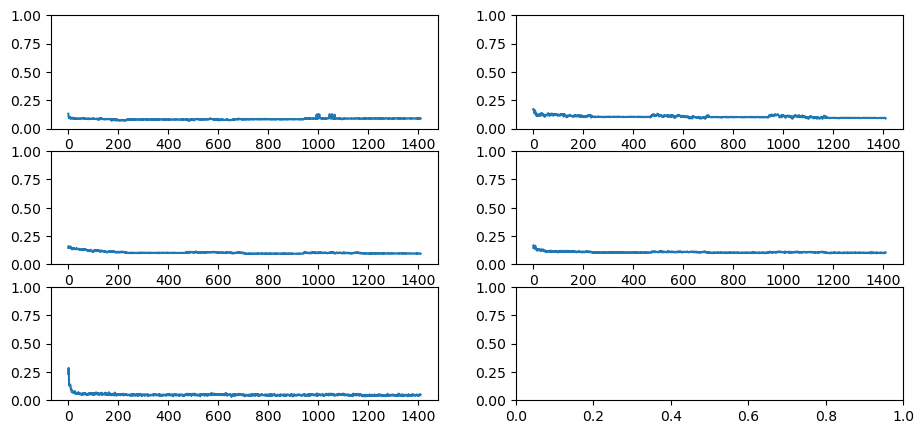

In [76]:
run(model, lr=0.2)

> The accuracy is good, at 87.2%, and the outputs have a smooth distribution over $[0,10]$. The values $\in [0,0.25]$ represent barely 10% of the outputs.

In [78]:
set_seed(1)
model = get_model(act_gr).apply(iw)
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
for ms in zip(relus, convs): lsuv_init(*ms, xb.to(device))

before tensor(0.26) tensor(1.12)
before tensor(0.05) tensor(0.93)
before tensor(0.07) tensor(0.99)
before tensor(0.04) tensor(0.98)
before tensor(0.03) tensor(0.99)
before tensor(0.03) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
before tensor(0.00) tensor(1.00)
after tensor(0.00) tensor(1.00)

before tensor(0.13) tensor(0.84)
before tensor(0.15) tensor(0.97)
before tensor(0.08) tensor(0.96)
before tensor(0.07) tensor(0.98)
before tensor(0.04) tensor(0.98)
before tensor(0.03) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.02) tensor(0.99)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before tensor(0.01) tensor(1.00)
before ten

0 0.47980526668230694 0.8257
1 0.3957940753698349 0.8559833333969116
2 0.3451091584444046 0.8717833333651225


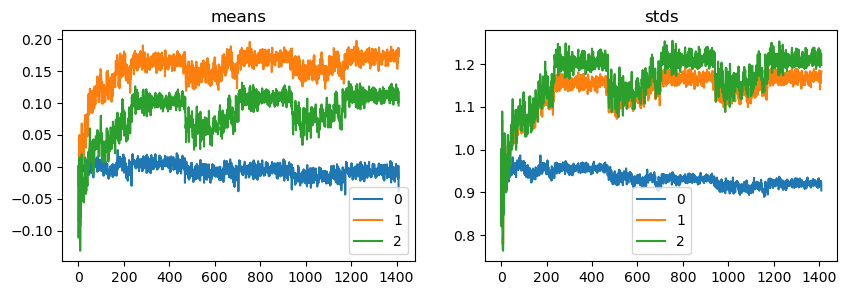

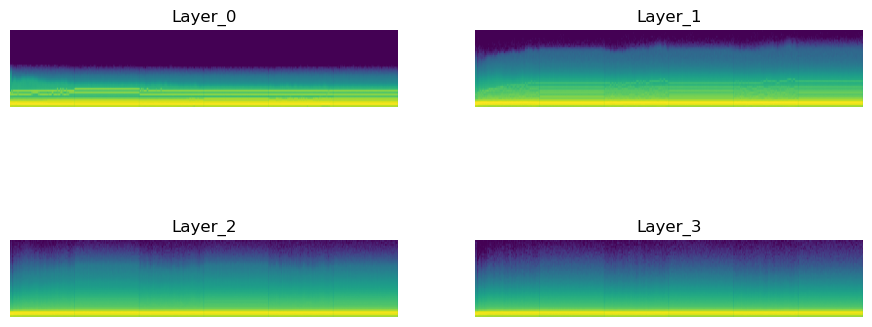

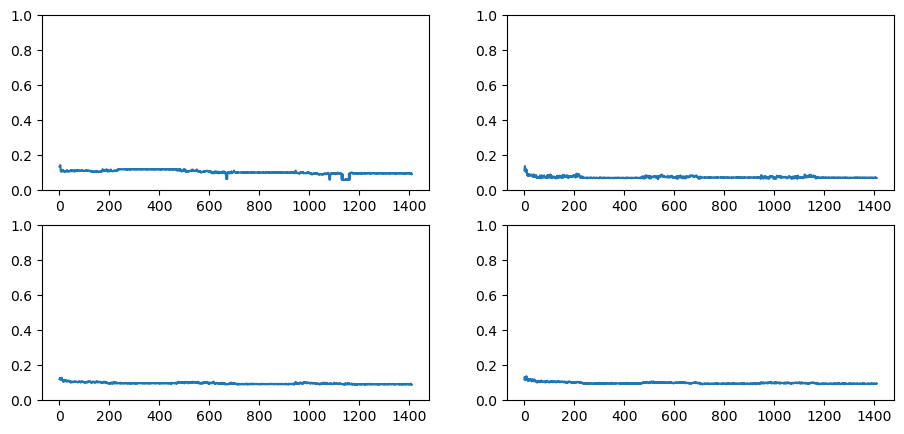

In [79]:
run(model, lr=0.2, layer_type=GeneralRelu)